In [25]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
import json
import sys
sys.path.append("..")
import util    # helper functions

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Get relevant secrets and variables

print("Connecting to Hopsworks...")
hopsworks_key = os.getenv("HOPSWORKS_API_KEY") 
hopsworks_project_name = os.getenv("HOPSWORKS_PROJECT")
project = hopsworks.login(project=hopsworks_project_name, api_key_value=hopsworks_key) 
fs = project.get_feature_store()

with open("../city_config/gothenburg_femman.json") as f:
    city_config = json.load(f)

country = city_config["city_name"]
city = city_config["country_name"]
street = city_config["street_name"]
LAT = city_config["city_lat"]
LON = city_config["city_lon"]
SENSOR = city_config["sensors"][0] 
FG_VERSIONS = city_config["fg_versions"]

feature_view = city_config["feature_view"]
feature_view_name = feature_view['name']
feature_view_version = feature_view['version']

Connecting to Hopsworks...
2025-11-08 14:12:33,345 INFO: Initializing external client
2025-11-08 14:12:33,346 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-08 14:12:35,348 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271989


In [3]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

forecast_fg = fs.get_feature_group(            # keeping forecast features separate
    name='weather_forecast_features',
    version=1,
)

In [4]:
# Select features for training data.
selected_features = air_quality_fg.select(['pm2_5', 'date']).join(weather_fg.select_features(), on=['city'])

2025-11-08 14:12:40,232 INFO: Using ['wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'temperature_2m_max', 'country', 'street'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


In [5]:
selected_features

In [6]:
feature_view = fs.get_or_create_feature_view(
    name=feature_view_name,
    description="Weather features with air quality (pm2.5) as the target",
    version=feature_view_version,
    labels=['pm2_5'],
    query=selected_features,
)

In [7]:
# Time-series split of train/test data
start_date_test_data = "2025-05-01"

# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [8]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.76s) 


In [9]:
X_train

,date,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,temperature_2m_max,country,street
0,2019-11-06 00:00:00+00:00,15.3,30.2,54,2.2,Sweden,Femman
1,2019-11-07 00:00:00+00:00,10.3,20.2,68,3.6,Sweden,Femman
2,2019-11-08 00:00:00+00:00,18.7,36.0,107,7.3,Sweden,Femman
3,2019-11-09 00:00:00+00:00,12.4,23.0,26,3.8,Sweden,Femman
4,2019-11-10 00:00:00+00:00,13.6,25.9,53,2.5,Sweden,Femman
...,...,...,...,...,...,...,...
1651,2025-04-26 00:00:00+00:00,12.5,32.0,113,13.7,Sweden,Femman
1652,2025-04-27 00:00:00+00:00,19.7,45.7,192,13.1,Sweden,Femman
1653,2025-04-28 00:00:00+00:00,23.3,47.5,239,14.7,Sweden,Femman
1654,2025-04-29 00:00:00+00:00,19.2,43.2,279,14.9,Sweden,Femman


In [10]:
X_features = X_train.drop(columns=['date', 'country', 'street'])
X_test_features = X_test.drop(columns=['date', 'country', 'street'])

In [11]:
X_features

,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,temperature_2m_max
0,15.3,30.2,54,2.2
1,10.3,20.2,68,3.6
2,18.7,36.0,107,7.3
3,12.4,23.0,26,3.8
4,13.6,25.9,53,2.5
...,...,...,...,...
1651,12.5,32.0,113,13.7
1652,19.7,45.7,192,13.1
1653,23.3,47.5,239,14.7
1654,19.2,43.2,279,14.9


In [12]:
y_train

,pm2_5
0,15.0
1,16.0
2,20.0
3,14.0
4,14.0
...,...
1651,18.0
1652,42.0
1653,41.0
1654,27.0


In [26]:
# Hyperparameter tuning:
# Define the hyperparameter grid
param_dist = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.1, 0.05, 0.01],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1],
    'n_estimators': [100, 300, 500],
    'gamma': [0, 1, 5]
}

# Create the XGBoost model object
xgb_model = XGBRegressor()

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=50,        # number of random combinations
    cv=5,
    scoring='neg_mean_squared_error',  # regression metric
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_features, y_train)

best_params = random_search.best_params_ 
print("Best hyperparameters:", best_params)
print("Best MSE:", -random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=   0.1s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=1, gamma=1, learning_rate=0.01, max_depth=10, n_estimators=100, 

In [27]:
# Modelling

# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor(**best_params, random_state=42)

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [28]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 155.2360340990617
R squared: -0.12662645435440667


In [29]:
df = y_test
df['predicted_pm25'] = y_pred

In [30]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm2_5,predicted_pm25,date
1656,54.0,30.306709,2025-05-01 00:00:00+00:00
1657,47.0,23.208927,2025-05-02 00:00:00+00:00
1658,24.0,23.106226,2025-05-03 00:00:00+00:00
1659,9.0,19.191200,2025-05-04 00:00:00+00:00
1660,20.0,23.109676,2025-05-05 00:00:00+00:00


In [31]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "../air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

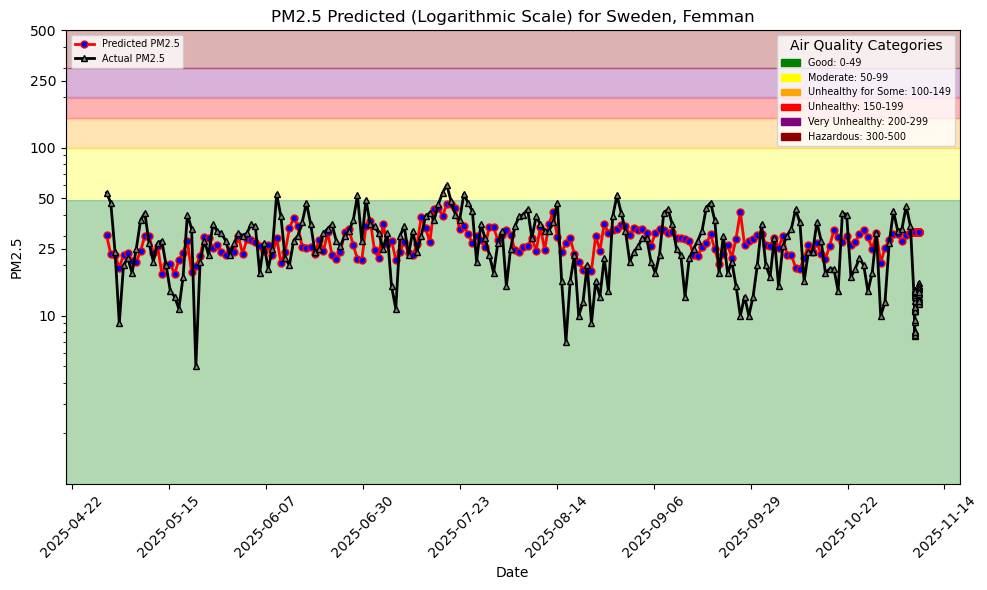

In [32]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

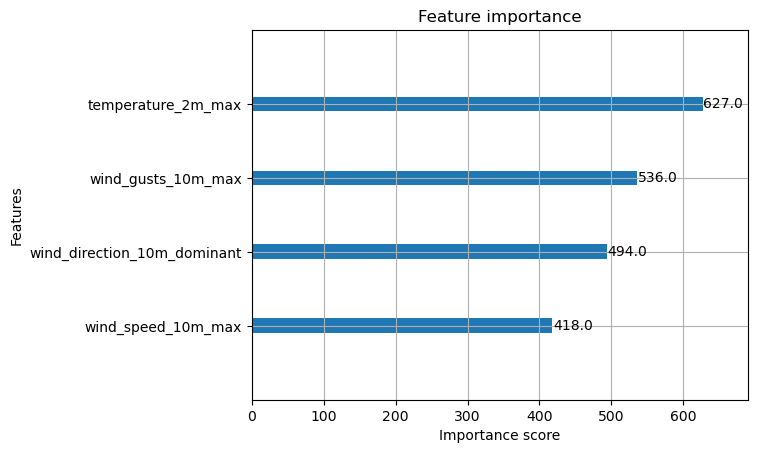

In [33]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

In [34]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [35]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [36]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/model.json: 0…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/images/featur…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/images/pm25_h…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/model_schema.json: 0.000%|        …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1271989/models/air_quality_xgboost_model/2


Model(name: 'air_quality_xgboost_model', version: 2)